<a href="https://colab.research.google.com/github/adampotton/Cognitive_AI_CW/blob/main/Q2D_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contrast based attention

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import time
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Define Model with Contrast Attention Layers

In [51]:
img_size_div4 = 45

class ContrastAttentionLayer(nn.Module):
    def __init__(self, in_channels):
        super(ContrastAttentionLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Compute gradient (difference between adjacent pixels)
        grad_x = x[:, :, :, 1:] - x[:, :, :, :-1]  # Difference along x-axis
        grad_y = x[:, :, 1:, :] - x[:, :, :-1, :]  # Difference along y-axis

        # Pad gradients to the original image size (match height and width)
        grad_x = F.pad(grad_x, (0, 1, 0, 0), mode='constant', value=0)  # Pad x-axis
        grad_y = F.pad(grad_y, (0, 0, 0, 1), mode='constant', value=0)  # Pad y-axis

        # Combine gradients to get contrast map
        contrast_map = torch.abs(grad_x) + torch.abs(grad_y)  # Absolute sum of gradients

        # Normalize contrast map
        contrast_map = F.interpolate(contrast_map, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=True)
        contrast_map = torch.sigmoid(contrast_map)  # Apply sigmoid to normalize the attention weights

        return contrast_map

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(16 * 45 * 45, 128)  # Adjust size according to your image size
        self.fc2 = nn.Linear(128, 3)
        self.attn1 = ContrastAttentionLayer(8)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        attn1_weights = self.attn1(x)  # Compute attention for first layer
        x = x * attn1_weights  # Apply contrast-based attention
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 16 * 45 * 45)  # Flatten for fully connected layer
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x, attn1_weights


### Load and Edit Data

In [49]:
img_size = img_size_div4 * 4 # Define image size

train_transform = transforms.Compose([ # Define transformations for training
    transforms.Resize((img_size, img_size)),  # Resize images to the desired size
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=4),   # Randomly rotate images by up to 15 degrees
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

test_transform = transforms.Compose([ # Define transformations for testing (no augmentation)
    transforms.Resize((img_size, img_size)),  # Resize images to the desired size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Define paths to your train and test directories
train_dir = '/content/drive/MyDrive/Cognitive_AI/shoes/train'
test_dir = '/content/drive/MyDrive/Cognitive_AI/shoes/test'

batch_size = 20
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform) # Load datasets using ImageFolder
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Create DataLoader for batching
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Train the Model

In [52]:
lr = 0.0006 # Learning rate
num_epochs = 20 # Number of epochs for training

model = CNN() # Initialise a model
criterion = nn.CrossEntropyLoss()  # Loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
t = time.time() # Start timer
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader: # Loop through images and labels to train
        optimizer.zero_grad()
        output,_ = model(images)
        loss = criterion(output, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    time_elapsed = time.time() - t # Calculate time elapsed
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Time: {time_elapsed}")


Epoch 1/20, Loss: 1.2252, Accuracy: 0.2968, Time: 20.030720710754395
Epoch 2/20, Loss: 1.0730, Accuracy: 0.3938, Time: 38.554460763931274
Epoch 3/20, Loss: 1.0448, Accuracy: 0.4473, Time: 59.914223194122314
Epoch 4/20, Loss: 0.9964, Accuracy: 0.5162, Time: 78.06342339515686
Epoch 5/20, Loss: 0.9311, Accuracy: 0.5795, Time: 96.7868480682373
Epoch 6/20, Loss: 0.8789, Accuracy: 0.5935, Time: 114.61855435371399
Epoch 7/20, Loss: 0.8121, Accuracy: 0.6540, Time: 133.79245162010193
Epoch 8/20, Loss: 0.7565, Accuracy: 0.6850, Time: 151.12850975990295
Epoch 9/20, Loss: 0.6773, Accuracy: 0.7328, Time: 169.28967690467834
Epoch 10/20, Loss: 0.6046, Accuracy: 0.7581, Time: 187.20980715751648
Epoch 11/20, Loss: 0.5385, Accuracy: 0.7820, Time: 206.12740278244019
Epoch 12/20, Loss: 0.4730, Accuracy: 0.8087, Time: 223.84570860862732
Epoch 13/20, Loss: 0.4769, Accuracy: 0.7989, Time: 241.39387130737305
Epoch 14/20, Loss: 0.4454, Accuracy: 0.8242, Time: 259.40049028396606
Epoch 15/20, Loss: 0.4054, Accur

### Testing the Model

In [53]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to track gradients during evaluation
    for images, labels in test_loader:
        output,_ = model(images)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.6053


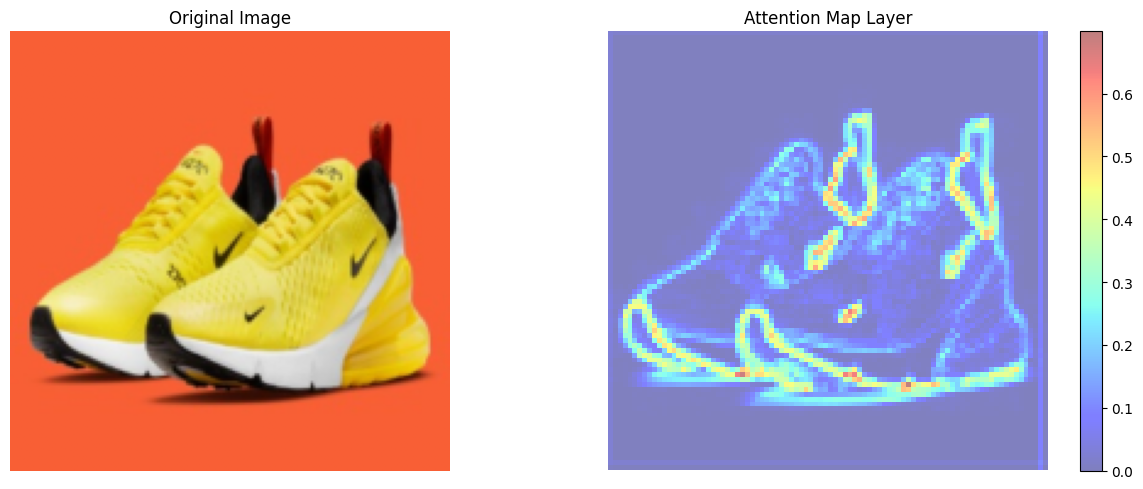

In [64]:
def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    return img * std + mean

# Set model to evaluation mode
model.eval()

# Get a sample image from the test_loader
data_iter = iter(test_loader)
random_batch = random.choice([batch for batch in data_iter])
image, label = random_batch

# Get the output and attention maps
with torch.no_grad():
    output, attn1_weights = model(image)

# Convert the attention weights to numpy for visualization
attn1_weights = attn1_weights.squeeze().cpu().numpy()  # Remove batch dimension

# Normalize the attention weights for visualization
attn1_weights = (attn1_weights - attn1_weights.min()) / (attn1_weights.max() - attn1_weights.min())

mean_attn1 = attn1_weights.mean(axis=1)

# Convert the image to numpy (H, W, C) format for visualization
image = image[0].unsqueeze(0)
original_image = denormalize(image.clone(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
original_image = original_image.squeeze().permute(1, 2, 0).cpu().detach().numpy()
original_image = np.clip(original_image, 0, 1)

# Plot the original image and attention maps
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# Original image
ax[0].imshow(original_image)
ax[0].set_title("Original Image")
ax[0].axis('off')

# Attention map for the first layer
ax1 = ax[1].imshow(mean_attn1[0], cmap='jet', alpha=0.5)  # Overlay the attention map with transparency
ax[1].set_title("Attention Map Layer")
ax[1].axis('off')

fig.colorbar(ax1,ax=ax[1])
plt.tight_layout()
plt.show()
